# Imports

## Pakages

In [2]:
# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os, datetime, copy
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_pacf as pacf, plot_acf as acf
from statsmodels.tsa.stattools import adfuller as adf

# Models
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, metrics, losses

2024-03-28 09:51:50.246098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 09:51:50.266423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 09:51:50.266442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 09:51:50.266860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 09:51:50.270400: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.__version__

'2.15.0'

In [4]:
tf.config.list_physical_devices()

2024-03-28 09:51:53.037057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 09:51:53.135759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-28 09:51:53.136068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Notebook Config

In [4]:
class cfg:
    base_dir = os.getcwd()
    data_dir = f'{base_dir}\\DATA\\XAUUSD.xls'
    is_validation_phase = True
    color = sns.color_palette()
    split_date = '2023-05-01'

## Helper Functions

In [5]:
def adf_test(data):
    result = adf(data)
    if result[1]>0.05:
        print("Data is non-Stationary because p-value > 0.05 so null hypothesis cannot be rejected")
    else:
        print("Data is non-Stationary because p-value < 0.05 so null hypothesis rejected")
    print(f"p-value={result[1]}")

## Importing Data

In [6]:
df = pd.read_csv(cfg.data_dir, header=1)
df.head()

,Date,Open,High,Low,Close,Change(Pips),Change(%)
0,7/4/2023 0:00,1921.07,1930.22,1920.34,1929.65,858,0.44
1,7/3/2023 0:00,1917.70,1930.50,1910.11,1921.17,347,0.18
2,7/2/2023 0:00,1920.30,1920.30,1917.50,1917.70,-260,-0.14
3,6/30/2023 0:00,1908.71,1922.61,1900.57,1919.20,1049,0.55
4,6/29/2023 0:00,1909.47,1913.00,1893.16,1908.76,-71,-0.04


In [7]:
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.sort_index(ascending=True, inplace=True)
df.tail()

,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2023-06-29,1909.47,1913.00,1893.16,1908.76,-71,-0.04
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049,0.55
2023-07-02,1920.30,1920.30,1917.50,1917.70,-260,-0.14
2023-07-03,1917.70,1930.50,1910.11,1921.17,347,0.18
2023-07-04,1921.07,1930.22,1920.34,1929.65,858,0.44


In [8]:
# some of the dates are missing ==> reindexing
idx = pd.date_range(df.index[0], df.index[-1])
df = df.reindex(idx, fill_value=np.NAN)
# iterpolating missing values
df = df.interpolate(method='linear')
df

,Open,High,Low,Close,Change(Pips),Change(%)
2021-07-04,1787.220,1787.730,1785.000,1786.39,-83.0,-0.050
2021-07-05,1786.680,1794.000,1783.800,1791.15,447.0,0.250
2021-07-06,1790.850,1814.890,1789.890,1795.68,483.0,0.270
2021-07-07,1795.280,1809.500,1793.410,1803.22,794.0,0.440
2021-07-08,1803.290,1818.000,1793.900,1803.75,46.0,0.030
...,...,...,...,...,...,...
2023-06-30,1908.710,1922.610,1900.570,1919.20,1049.0,0.550
2023-07-01,1914.505,1921.455,1909.035,1918.45,394.5,0.205
2023-07-02,1920.300,1920.300,1917.500,1917.70,-260.0,-0.140
2023-07-03,1917.700,1930.500,1910.110,1921.17,347.0,0.180


# Data Visualization

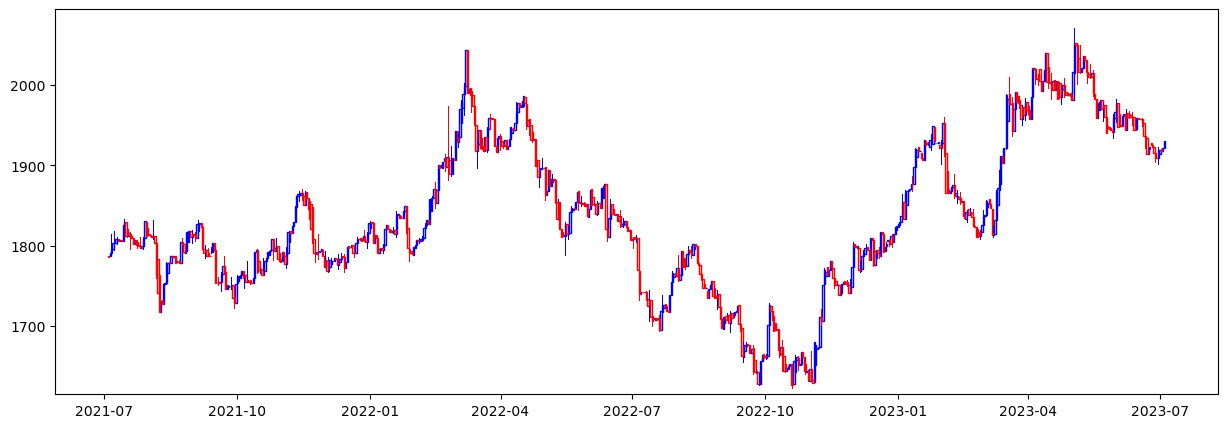

In [9]:
inc = df[df.Open<=df.Close]
dec = df[df.Open> df.Close]


plt.figure(figsize=(15,5))
plt.bar(inc.index, (inc.Close-inc.Open), width=0.9, bottom=inc.Open, edgecolor='b', fill=False)
plt.bar(dec.index, (dec.Close-dec.Open), width=0.9, bottom=dec.Open, edgecolor='r', fill=False)
plt.bar(inc.index, (inc.High-inc.Close), width=0.2, bottom=inc.Close, color='b', fill=True)
plt.bar(inc.index, (inc.Open-inc.Low), width=0.2, bottom=inc.Low, color='b', fill=True)
plt.bar(dec.index, (dec.Close-dec.Low), width=0.2, bottom=dec.Low, color='r', fill=True)
plt.bar(dec.index, (dec.High-dec.Open), width=0.2, bottom=dec.Open, color='r', fill=True)

plt.show()

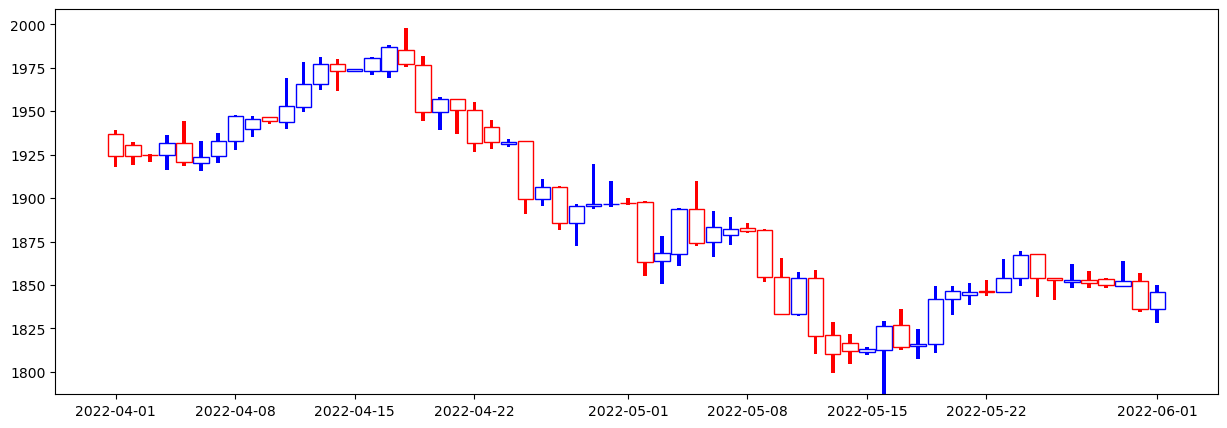

In [10]:
index_range = ('2022-04-01','2022-06-01')

inc = df[df.Open<=df.Close].loc[index_range[0]:index_range[1]]
dec = df[df.Open> df.Close].loc[index_range[0]:index_range[1]]


plt.figure(figsize=(15,5))
plt.bar(inc.index, (inc.Close-inc.Open), width=0.9, bottom=inc.Open, edgecolor='b', fill=False)
plt.bar(dec.index, (dec.Close-dec.Open), width=0.9, bottom=dec.Open, edgecolor='r', fill=False)
plt.bar(inc.index, (inc.High-inc.Close), width=0.2, bottom=inc.Close, color='b', fill=True)
plt.bar(inc.index, (inc.Open-inc.Low), width=0.2, bottom=inc.Low, color='b', fill=True)
plt.bar(dec.index, (dec.Close-dec.Low), width=0.2, bottom=dec.Low, color='r', fill=True)
plt.bar(dec.index, (dec.High-dec.Open), width=0.2, bottom=dec.Open, color='r', fill=True)

plt.show()

- Data is not seasonal and doesn't have a clear trend

# Models

## ARIMA

### Checking Stationarity

- data is obviously <font color='red'>non stationary<font color='black'> but we're going to use a couple of methods to prove it.

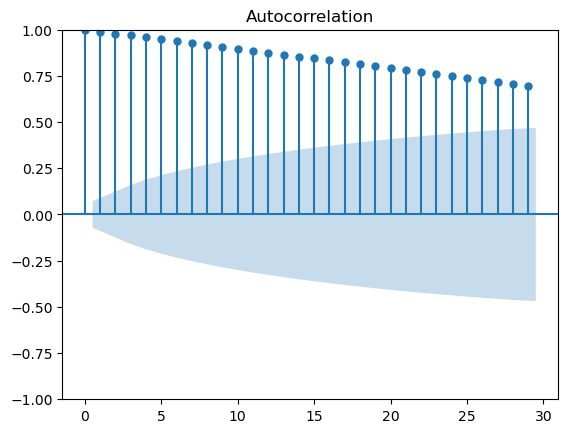

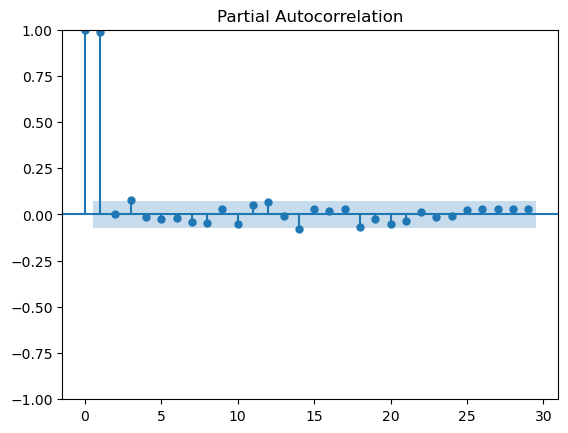

In [11]:
# PACF Plot
acfplot = acf(df.Close)
pacfplot = pacf(df.Close)

In [12]:
# ADF test
adf_test(df.Close)

Data is non-Stationary because p-value > 0.05 so null hypothesis cannot be rejected
p-value=0.4552403058585401


### Transform data with diffrencing

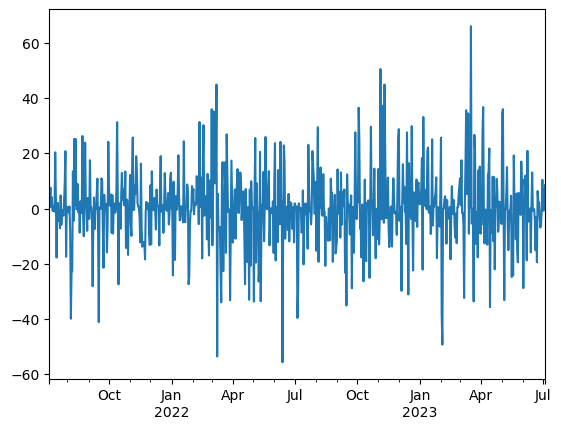

In [13]:
diff = df.Close.diff().dropna()
diff.plot()
plt.show()

In [14]:
adf_test(diff)

Data is non-Stationary because p-value < 0.05 so null hypothesis rejected
p-value=0.0


- <font color='red'>first diff is stationary

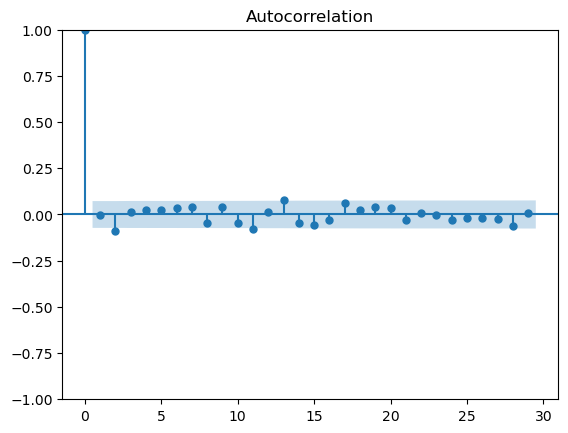

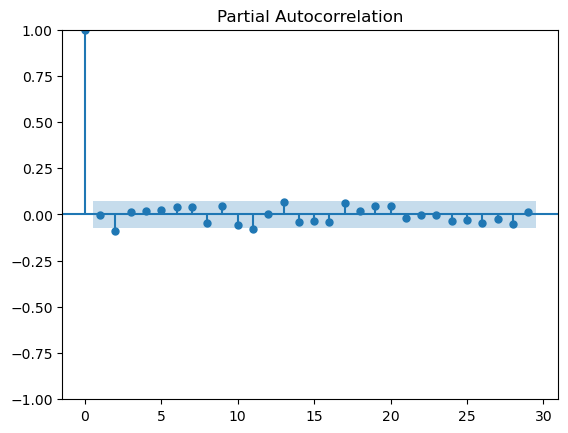

In [15]:
acfplot = acf(diff)
pacfplot = pacf(diff)

- <font color='red'> with d=1 we may be over differencing <font color='black'>so d could be 1 or 0

### Tran/Eval Split

In [16]:
df_train_arima = df.Close.loc[df.index<cfg.split_date]
df_eval_arima = df.Close.loc[df.index>=cfg.split_date]

df_train_arima.index = pd.DatetimeIndex(df_train_arima.index, freq='D')#.to_period('D')
df_eval_arima.index = pd.DatetimeIndex(df_eval_arima.index, freq='D')#.to_period('D')

In [17]:
df_train_arima.index

DatetimeIndex(['2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07',
               '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11',
               '2021-07-12', '2021-07-13',
               ...
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', length=666, freq='D')

### Model

In [18]:
# Model Config
p, d, q = 3,0,3

# model
arima = ARIMA(df_train_arima, order=(p,d,q))
fit = arima.fit()
fit.summary()

E:\Anaconda3\envs\py310-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Anaconda3\envs\py310-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\Anaconda3\envs\py310-gpu\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  666
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -2676.816
Date:                Mon, 17 Jul 2023   AIC                           5369.633
Time:                        14:20:46   BIC                           5405.643
Sample:                    07-04-2021   HQIC                          5383.585
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1820.7953     49.711     36.627      0.000    1723.363    1918.228
ar.L1          0.2094      0.090      2.325      0.020       0.033       0.386
ar.L2         -0.1322      0.102     -1.291      0.197      -0.333       0.068
ar.L3          0.8949      0.084     10.671      0.000       0.731       1.059
ma.L1          0.7859      0.098      8.059      0.000       0.595       0.977
ma.L2          0.8683      0.106      8.181      0.000       0.660       1.076
ma.L3          0.0045      0.039      0.115      0.909      -0.072       0.081
sigma2       180.2826      6.844     26.341      0.000     166.868     193.697
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               182.09
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

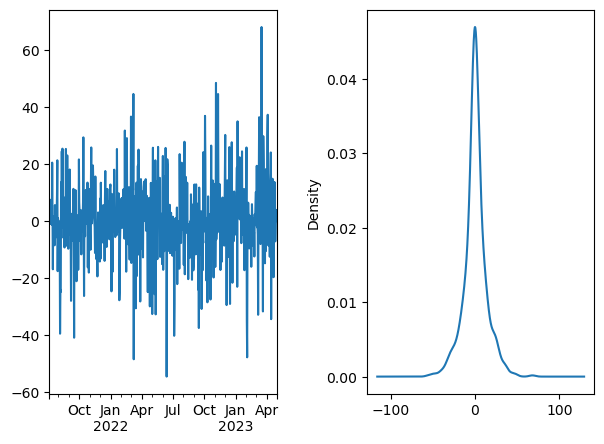

In [19]:
# plotting residuals
residuals = fit.resid[1:]
fig, axes = plt.subplots(1,2)
residuals.plot(ax=axes[0])
residuals.plot(ax=axes[1], kind='kde')
fig.tight_layout(pad=2.0)
plt.show()

- residuals are random and density is normal

### Prediction

<Axes: >

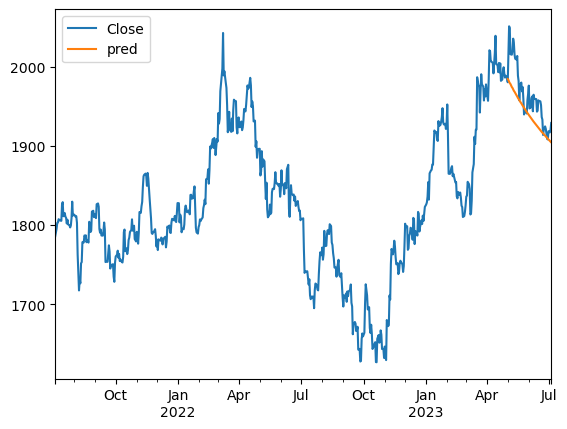

In [21]:
pred_arima = fit.forecast(df_eval_arima.shape[0])
df_pred_arima = df.copy()
df_pred_arima['pred'] = [np.NAN]*df_train_arima.shape[0] + pred_arima.values.tolist()
df_pred_arima[['Close','pred']].plot()

In [22]:
df_pred_arima[df_pred_arima.pred.notna()]

,Open,High,Low,Close,Change(Pips),Change(%),pred
2023-05-01,1986.950,2005.350,1977.120,1981.13,-582.0,-0.290,1985.210388
2023-05-02,1981.630,2018.940,1978.500,2015.84,3421.0,1.700,1983.988733
2023-05-03,2015.100,2071.320,2008.900,2051.93,3683.0,1.790,1981.721202
2023-05-04,2052.780,2059.390,2030.770,2049.80,-298.0,-0.150,1980.051804
2023-05-05,2049.790,2052.750,1999.630,2016.58,-3321.0,-1.650,1978.908721
...,...,...,...,...,...,...,...
2023-06-30,1908.710,1922.610,1900.570,1919.20,1049.0,0.550,1908.668441
2023-07-01,1914.505,1921.455,1909.035,1918.45,394.5,0.205,1907.773029
2023-07-02,1920.300,1920.300,1917.500,1917.70,-260.0,-0.140,1906.838658
2023-07-03,1917.700,1930.500,1910.110,1921.17,347.0,0.180,1905.950771


## LSTM NN model with MIXED inputs

### preping data

In [271]:
window_size = 7

In [272]:
temp_ds = tf.data.Dataset.from_tensor_slices(df.Close.values)
temp_ds = temp_ds.window(size=window_size, drop_remainder=True, shift=1)
temp_ds = temp_ds.flat_map(lambda window: window.batch(window_size))
temp_ds = temp_ds.map(lambda window: (window[:-1], window[-1]))

feat = []
labels = []
for x,y in temp_ds:
    feat.append(x.numpy())
    labels.append(y.numpy())
feat = np.array(feat)
labels = np.array(labels)

In [273]:
df_LSTM = df.Close.iloc[-feat.shape[0]:].copy()

In [274]:
df_LSTM = pd.DataFrame(df.Close.iloc[-feat.shape[0]:].copy())
for i in range(feat.shape[1]):
    df_LSTM[f'T-{window_size-i-1}'] = feat[:,i]

In [275]:
df_LSTM['year'] = df_LSTM.index.year
df_LSTM['day_of_year'] = df_LSTM.index.day_of_year
df_LSTM['day'] = df_LSTM.index.day
df_LSTM['day_of_week'] = df_LSTM.index.day_of_week
df_LSTM['week'] = df_LSTM.index.week
df_LSTM['month'] = df_LSTM.index.month

C:\Users\Amirhossein\AppData\Local\Temp\ipykernel_17596\1579336381.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_LSTM['week'] = df_LSTM.index.week


In [276]:
df_LSTM

,Close,T-6,T-5,T-4,T-3,T-2,T-1,year,day_of_year,day,day_of_week,week,month
2021-07-10,1807.065,1786.39,1791.15,1795.680,1803.220,1803.750,1807.890,2021,191,10,5,27,7
2021-07-11,1806.240,1791.15,1795.68,1803.220,1803.750,1807.890,1807.065,2021,192,11,6,27,7
2021-07-12,1806.950,1795.68,1803.22,1803.750,1807.890,1807.065,1806.240,2021,193,12,0,28,7
2021-07-13,1805.820,1803.22,1803.75,1807.890,1807.065,1806.240,1806.950,2021,194,13,1,28,7
2021-07-14,1826.230,1803.75,1807.89,1807.065,1806.240,1806.950,1805.820,2021,195,14,2,28,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,1919.200,1923.04,1925.29,1922.280,1915.390,1909.580,1908.760,2023,181,30,4,26,6
2023-07-01,1918.450,1925.29,1922.28,1915.390,1909.580,1908.760,1919.200,2023,182,1,5,26,7
2023-07-02,1917.700,1922.28,1915.39,1909.580,1908.760,1919.200,1918.450,2023,183,2,6,26,7
2023-07-03,1921.170,1915.39,1909.58,1908.760,1919.200,1918.450,1917.700,2023,184,3,0,27,7


### Train/Eval Split

In [290]:
if cfg.is_validation_phase:
    df_train = df_LSTM.loc[cfg.split_date>df_LSTM.index].copy()
    df_eval = df_LSTM.loc[cfg.split_date<=df_LSTM.index].copy()
    
    dates_train = df_train.index
    x_seq_train = df_train.iloc[:, 1:window_size].values.reshape(-1, window_size-1, 1)
    x_tab_train = df_train.iloc[:, window_size:].values.astype(np.float64)
    y_train = df_train.Close.values.astype(np.float64)
    
    dates_eval = df_eval.index
    x_seq_eval = df_eval.iloc[:, 1:window_size].values.reshape(-1, window_size-1, 1)
    x_tab_eval = df_eval.iloc[:, window_size:].values.astype(np.float64)
    y_eval = df_eval.Close.values.astype(np.float64)
    
else:
    df_train = df_LSTM.copy()
    
    dates_train = df_train.index
    x_seq_train = df_train.iloc[:, 1:window_size].values.reshape(-1, window_size-1, 1)
    x_tab_train = df_train.iloc[:, window_size:].values.astype(np.float64)
    y_train = df_train.Close.values.astype(np.float64)

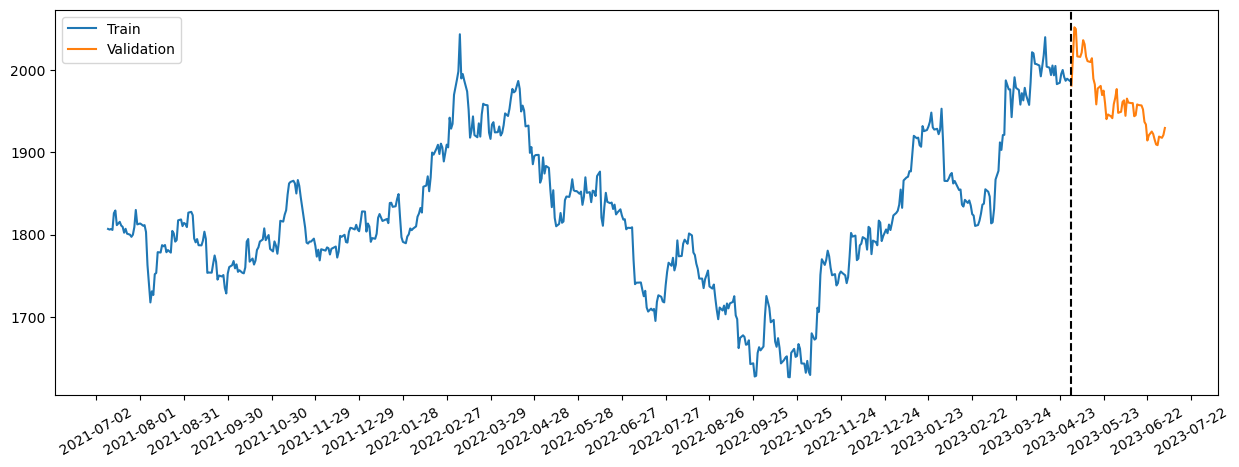

In [295]:
f, ax = plt.subplots(figsize=(15,5))
ax.plot(dates_train, y_train)
if cfg.is_validation_phase:
    ax.plot(dates_eval, y_eval)
    ax.axvline(x=pd.DatetimeIndex([cfg.split_date])[0], color='black', ls='--')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=30)
plt.legend(['Train', 'Validation'])
plt.show()

### Model

In [368]:
# config
tf.keras.backend.clear_session()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

if cfg.is_validation_phase:
    validation_data = ([x_seq_eval, x_tab_eval], y_eval)
else:
    validation_data = None

# model
LSTM_model = Sequential([
    layers.LSTM(128, return_sequences=False, input_shape=(window_size-1,1), activation='relu'),
    #layers.LSTM(64, return_sequences=False),
    layers.Dense(16, activation='relu'),
])

DENSE_model = Sequential([
    layers.Dense(16, activation='relu', input_shape=(x_tab_train.shape[1],)),
    #layers.Dense(32, activation='relu'),
    #layers.Dense(32, activation='relu'),
])

inputs = layers.concatenate([LSTM_model.output, DENSE_model.output])
l = layers.Dense(32, activation='relu')(inputs)
l = layers.Dense(1, activation='linear')(l)

MIX_model = Model(inputs=[LSTM_model.input, DENSE_model.input], outputs=l)

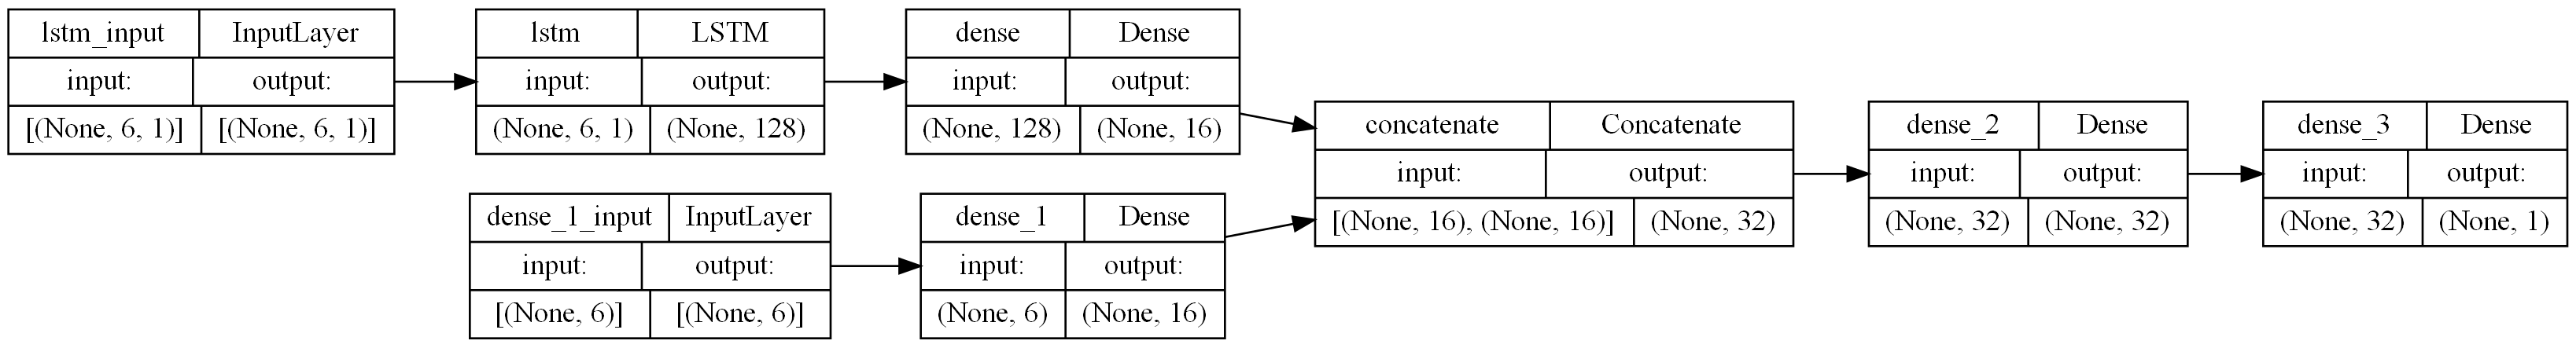

In [369]:
# plotting model
tf.keras.utils.plot_model(
    MIX_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=False,
    dpi=96*2,
    layer_range=None,
    show_layer_activations=False)

In [370]:
MIX_model.compile(loss='mse', optimizer=optimizers.Adam(0.0001), metrics=['mean_absolute_error'])
history = MIX_model.fit([x_seq_train, x_tab_train], y_train, 
                        validation_data =validation_data, 
                        epochs=500, 
                        callbacks=[es]
                       )
print('-'*100)
#print(min(history.history['loss']),'-------', min(history.history['val_loss']))



Epoch 1/500
21/21 [==============================] - 1s 22ms/step - loss: 4482154.5000 - mean_absolute_error: 2115.1389 - val_loss: 4818826.5000 - val_mean_absolute_error: 2194.9011
Epoch 2/500
21/21 [==============================] - 0s 12ms/step - loss: 4023009.0000 - mean_absolute_error: 2003.5645 - val_loss: 4245702.5000 - val_mean_absolute_error: 2060.2290
Epoch 3/500
21/21 [==============================] - 0s 13ms/step - loss: 3513529.7500 - mean_absolute_error: 1872.3606 - val_loss: 3682929.7500 - val_mean_absolute_error: 1918.8363
Epoch 4/500
21/21 [==============================] - 0s 13ms/step - loss: 2948211.0000 - mean_absolute_error: 1714.3881 - val_loss: 2943551.2500 - val_mean_absolute_error: 1715.4219
Epoch 5/500
21/21 [==============================] - 0s 12ms/step - loss: 2268723.0000 - mean_absolute_error: 1503.5358 - val_loss: 2161461.7500 - val_mean_absolute_error: 1469.9696
Epoch 6/500
21/21 [==============================] - 0s 12ms/step - loss: 1520615.1250 - m

21/21 [==============================] - 0s 12ms/step - loss: 354.8062 - mean_absolute_error: 14.7380 - val_loss: 414.9165 - val_mean_absolute_error: 17.6948
Epoch 97/500
21/21 [==============================] - 0s 12ms/step - loss: 358.6048 - mean_absolute_error: 14.7546 - val_loss: 168.9067 - val_mean_absolute_error: 9.6756
Epoch 98/500
21/21 [==============================] - 0s 11ms/step - loss: 326.8871 - mean_absolute_error: 14.0322 - val_loss: 218.8578 - val_mean_absolute_error: 11.7182
Epoch 99/500
21/21 [==============================] - 0s 11ms/step - loss: 323.4990 - mean_absolute_error: 14.0689 - val_loss: 180.2660 - val_mean_absolute_error: 10.7005
Epoch 100/500
21/21 [==============================] - 0s 11ms/step - loss: 357.5922 - mean_absolute_error: 14.7677 - val_loss: 168.2868 - val_mean_absolute_error: 9.7133
Epoch 101/500
21/21 [==============================] - 0s 15ms/step - loss: 324.4278 - mean_absolute_error: 14.0635 - val_loss: 318.8651 - val_mean_absolute_er

Epoch 144/500
21/21 [==============================] - 0s 12ms/step - loss: 314.7595 - mean_absolute_error: 13.6092 - val_loss: 155.4475 - val_mean_absolute_error: 9.0432
Epoch 145/500
21/21 [==============================] - 0s 11ms/step - loss: 299.0692 - mean_absolute_error: 13.2965 - val_loss: 333.6470 - val_mean_absolute_error: 15.4326
Epoch 146/500
21/21 [==============================] - 0s 11ms/step - loss: 294.9932 - mean_absolute_error: 13.3117 - val_loss: 335.3509 - val_mean_absolute_error: 15.5309
Epoch 147/500
21/21 [==============================] - 0s 11ms/step - loss: 293.8461 - mean_absolute_error: 13.1998 - val_loss: 387.9174 - val_mean_absolute_error: 17.0052
Epoch 148/500
21/21 [==============================] - 0s 11ms/step - loss: 298.4519 - mean_absolute_error: 13.3461 - val_loss: 182.1049 - val_mean_absolute_error: 10.4000
Epoch 149/500
21/21 [==============================] - 0s 11ms/step - loss: 294.8114 - mean_absolute_error: 13.1862 - val_loss: 226.5591 - va

Epoch 192/500
21/21 [==============================] - 0s 11ms/step - loss: 273.1714 - mean_absolute_error: 12.7177 - val_loss: 209.9871 - val_mean_absolute_error: 11.7207
Epoch 193/500
21/21 [==============================] - 0s 11ms/step - loss: 268.9958 - mean_absolute_error: 12.5477 - val_loss: 359.3865 - val_mean_absolute_error: 16.4172
Epoch 194/500
21/21 [==============================] - 0s 13ms/step - loss: 277.5145 - mean_absolute_error: 12.7678 - val_loss: 236.7979 - val_mean_absolute_error: 12.7326
----------------------------------------------------------------------------------------------------


In [371]:
MIX_model.save('Models/MIX_model')

INFO:tensorflow:Assets written to: Models/MIX_model\assets


INFO:tensorflow:Assets written to: Models/MIX_model\assets


In [372]:
#tf.keras.backend.clear_session()

In [373]:
#MIX_model = tf.keras.models.load_model('Models/MIX_model')

In [374]:
if cfg.is_validation_phase:
    pred_eval = MIX_model.predict(validation_data[0])
    print(np.sqrt(mean_squared_error(y_eval, pred_eval)))
    pred_train = MIX_model.predict([x_seq_train, x_tab_train])
    print(np.sqrt(mean_squared_error(y_train, pred_train)))
else:
    pred_train = MIX_model.predict([x_seq_train, x_tab_train])
    print(np.sqrt(mean_squared_error(y_train, pred_train)))

3/3 [==============================] - 0s 3ms/step
12.467865782383322
21/21 [==============================] - 0s 3ms/step
17.451992758007083


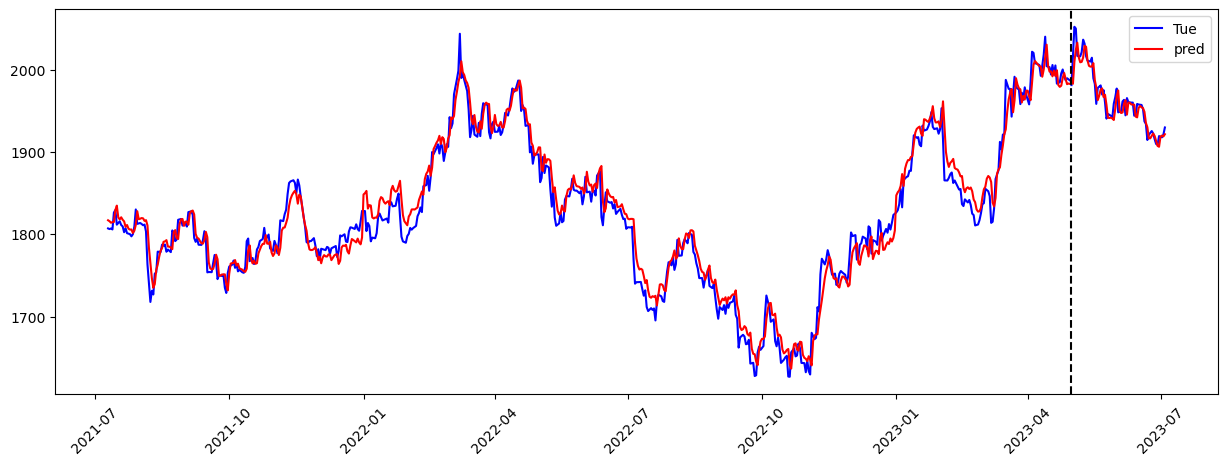

In [375]:
f, ax = plt.subplots(figsize=(15,5))
if cfg.is_validation_phase:
    ax.plot(dates_train, y_train, color='b')
    ax.plot(dates_train, pred_train, color='r')
    ax.plot(dates_eval, y_eval, color='b')
    ax.plot(dates_eval, pred_eval, color='r')
    
    ax.axvline(x=pd.DatetimeIndex([cfg.split_date])[0], color='black', ls='--')
else:
    ax.plot(m4_train_dates, p, color='r')
    ax.plot(m4_train_dates, m4_train_y, color='b')
ax.legend(['Tue', 'pred'])
plt.xticks(rotation = 45)
plt.show()